# Main Code

Import packages

In [ ]:
#packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import seaborn as sns
files_path = "./drive/MyDrive/MATH4995Project1/"

Read in datasets

In [ ]:
train = pd.read_csv(files_path + "application_train.csv")
bureau = pd.read_csv(files_path + "bureau.csv")
bureau_balance = pd.read_csv(files_path + "bureau_balance.csv")
prev_application = pd.read_csv(files_path + "previous_application.csv")
test = pd.read_csv(files_path + "application_test.csv")

Define functions for aggregation

In [ ]:
def agg_numeric(df, group_var, df_name):
    count = 0
    temp = [group_var]
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
        count += 1
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = df[group_var]
    handled = False
    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    handled = True
    # Need to create new column names
    columns = [group_var]
    if handled == True:
        count += 1
        handled = False
    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    if handled == False:
        handled = True
        count = 1
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    return agg

In [ ]:
def count_categorical(df, group_var, df_name):
 
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [ ]:
# logistic regression uses only application.csv
train_application_only = train
test_application_only = test

In [ ]:
train_application_only.shape

In [ ]:
test_application_only.shape

Aggregation

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')


In [ ]:
train.shape

Label & Onehot encoding

In [ ]:
# One Hot Encoding
def encoding(df):
  df_col = df.columns
  temp = pd.DataFrame.copy(df, deep = True)
  le = LabelEncoder()
  for i, col in enumerate(df_col):
    if temp[col].dtype == 'object':
      if len(list(temp[col].unique())) <= 2:
        temp[col] = le.fit_transform(np.array(temp[col].astype(str)).reshape((-1,)))
  encoded_df = pd.get_dummies(temp)
  return encoded_df

In [ ]:
train = encoding(train)
train_application_only = encoding(train_application_only)

In [ ]:
train.head(10)

In [ ]:
train_application_only.head(10)

*Handle* missing values 

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
#Calling function to handle missing values
missing_train = missing_values_table(train)
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 70])

missing_train_application_only = missing_values_table(train_application_only)
missing_train_application_only_vars = list(missing_train_application_only.index[missing_train_application_only['% of Total Values'] > 70])

In [ ]:
missing_train_application_only

In [ ]:
print(missing_train_application_only_vars)

Merging testing dataset

In [ ]:
# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

test = encoding(test)
test_application_only = encoding(test_application_only)
train_labels = train['TARGET']
train_application_only_labels = train_application_only['TARGET']
# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)
train_application_only, test_application_only = train_application_only.align(test_application_only, join = 'inner', axis = 1)
train['TARGET'] = train_labels
train_application_only['TARGET'] = train_application_only_labels

In [ ]:
train_application_only.shape

In [ ]:
test_application_only.shape

In [ ]:
missing_test = missing_values_table(test)
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 70])
missing_columns = list(set(missing_test_vars + missing_train_vars))
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

missing_test_application_only = missing_values_table(test_application_only)
missing_test_application_only_vars = list(missing_test_application_only.index[missing_test_application_only['% of Total Values'] > 70])
missing_application_only_columns = list(set(missing_test_application_only_vars + missing_train_application_only_vars))
train_application_only = train_application_only.drop(columns = missing_application_only_columns)
test_application_only = test_application_only.drop(columns = missing_application_only_columns)

In [ ]:
print("After handling missing values, the shape of train_application_only:")
print(train_application_only.shape)
print("After handling missing values, the shape of test_application_only:")
print(test_application_only.shape)

In [ ]:
#Correlation

# Calculate all correlations in training set dataframe
corrs = train.corr()
corrs = corrs.sort_values('TARGET', ascending = False)

# Calculate all correlations in application only training set dataframe
application_only_corrs = train_application_only.corr()
application_only_corrs = application_only_corrs.sort_values('TARGET', ascending = False)

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}
application_only_above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

for col in application_only_corrs:
    application_only_above_threshold_vars[col] = list(application_only_corrs.index[application_only_corrs[col] > threshold])
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

application_only_cols_to_remove = []
application_only_cols_seen = []
application_only_cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

for key, value in application_only_above_threshold_vars.items():
    # Keep track of columns already examined
    application_only_cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in application_only_cols_seen:
                application_only_cols_to_remove.append(x)
                application_only_cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

application_only_cols_to_remove = list(set(application_only_cols_to_remove))
print('Number of columns to remove for application only dataframe: ', len(application_only_cols_to_remove))

train_corrs_removed = train.drop(columns = cols_to_remove)
application_only_train_corrs_removed = train_application_only.drop(columns = application_only_cols_to_remove)

test_corrs_removed = test.drop(columns = cols_to_remove)

**Fill in Missing values** for application_only dataset

In [ ]:
#Filling in missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

#train_application_only
#test_application_only
train_application_only =  train_application_only.drop(columns = ['TARGET'])
# Median imputation of missing values
train_application_only_copy_df = train_application_only.copy()
test_application_only_copy_df = test_application_only.copy()
imputer_train = SimpleImputer(strategy = 'median')
imputer_test = SimpleImputer(strategy = 'median')
# Scale each feature to 0-1
scaler_train = MinMaxScaler(feature_range = (0, 1))
scaler_test = MinMaxScaler(feature_range = (0, 1))

# Fit on and transform training and test datasets
imputer_train.fit(train_application_only)
imputer_test.fit(test_application_only)
train_application_only = imputer_train.transform(train_application_only)
test_application_only = imputer_test.transform(test_application_only)

scaler_train.fit(train_application_only)
scaler_test.fit(test_application_only)
train_application_only = scaler_train.transform(train_application_only)
test_application_only = scaler_test.transform(test_application_only)

print('Training data shape: ', train_application_only.shape)
print('Testing data shape: ', test_application_only.shape)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
merged_train_labels = train['TARGET'].copy()
train_filled_na = train.drop(columns = ['TARGET'])
imputer_train = SimpleImputer(strategy = 'median')
scaler_train = MinMaxScaler(feature_range = (0, 1))
imputer_train.fit(train_filled_na)
train_filled_na = imputer_train.transform(train_filled_na)
scaler_train.fit(train_filled_na)
train_filled_na = scaler_train.transform(train_filled_na)
train_filled_na_df = pd.DataFrame(train_filled_na)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

imputer_test = SimpleImputer(strategy = 'median')
scaler_test = MinMaxScaler(feature_range = (0, 1))
imputer_train.fit(test)
test_filled_na = imputer_train.transform(test)
scaler_train.fit(test_filled_na)
test_filled_na = scaler_train.transform(test_filled_na)
test_filled_na_df = pd.DataFrame(test_filled_na)


In [ ]:
train

In [ ]:
train_application_only

In [ ]:
#save as csv before model training:
pd.DataFrame(train_application_only).to_csv("train_application_only_cleaned.csv", index = False)
pd.DataFrame(test_application_only).to_csv("test_application_only_cleaned.csv", index = False)
train_filled_na_df.to_csv("train_cleaned.csv", index =  False)
test_filled_na_df.to_csv("test_cleaned.csv", index = False)

In [ ]:
import pandas as pd
train_merged = pd.read_csv("train_cleaned.csv")
train_merged_labels = train_merged['TARGET']
train_merged_df = train_merged.drop(columns = ['TARGET'])

In [ ]:
test_cleaned_df = pd.read_csv("test_cleaned.csv")
test_cleaned_df

In [ ]:
train_application_only = pd.read_csv("drive/MyDrive/MATH4995Project1/train_application_only_cleaned.csv")
test_application_only = pd.read_csv("drive/MyDrive/MATH4995Project1/test_application_only_cleaned.csv")

# Logistic Regression

In [ ]:
#logistic regression with only original training dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Make the model with the specified regularization parameter
logistic_reg = LogisticRegression(C = 0.0001)

# Train on the training data
copy_train = train_application_only

k_fold = KFold(n_splits = 3, shuffle = True, random_state = 1)
first_fold_labels = []
first_fold_probs = []
fold_count = 0
for train_indices, valid_indices in k_fold.split(copy_train):
    logistic_reg.fit(copy_train.iloc[train_indices], train_application_only_labels[train_indices])
    logistic_reg_pred = logistic_reg.predict_proba(copy_train.iloc[valid_indices])[:, 1]
    if fold_count == 0:
        first_fold_labels = train_application_only_labels[valid_indices]
        first_fold_probs = logistic_reg_pred.copy()
    fold_count += 1


In [ ]:
test_filled_na_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420
0,0.000000,0.0,0.0,1.0,0.00,0.024654,0.238037,0.102453,0.184049,0.257380,0.333427,0.039545,0.782059,0.872086,0.121622,1.0,1.0,0.0,1.0,0.0,1.0,0.05,0.5,0.75,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.798495,0.923572,0.180263,0.0660,0.0590,0.9732,0.7552,0.0227,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.000011,0.0,0.0,1.0,0.00,0.016440,0.080785,0.084558,0.061350,0.491855,0.399339,0.033953,0.615631,0.744329,0.121622,1.0,1.0,0.0,1.0,0.0,0.0,0.05,0.5,0.75,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.595809,0.341111,0.490287,0.0928,0.0781,0.9816,0.7552,0.0227,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000034,0.0,1.0,1.0,0.00,0.040054,0.280965,0.378515,0.265849,0.260854,0.288794,0.033982,0.908313,0.448173,0.067568,1.0,1.0,0.0,1.0,0.0,0.0,0.05,0.5,0.75,0.608696,0.0,0.0,0.0,0.0,0.0,0.0,0.532916,0.818463,0.692134,0.0928,0.0781,0.9816,0.7552,0.0227,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000076,0.0,0.0,1.0,0.10,0.065721,0.695297,0.262078,0.695297,0.361760,0.628269,0.040755,0.915690,0.337114,0.121622,1.0,1.0,0.0,1.0,1.0,0.0,0.15,0.5,0.75,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.553401,0.596110,0.694076,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.000104,0.0,1.0,0.0,0.05,0.034920,0.263804,0.166995,0.263804,0.135340,0.680685,0.039905,0.831380,0.328607,0.216216,1.0,1.0,1.0,1.0,0.0,0.0,0.10,0.5,0.75,0.217391,0.0,0.0,0.0,0.0,1.0,1.0,0.203835,0.497875,0.587946,0.0928,0.0781,0.9816,0.7552,0.0227,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000115,0.0,1.0,1.0,0.00,0.055454,0.415673,0.181206,0.347648,0.344765,0.369099,0.014251,0.742180,0.680687,0.135135,1.0,1.0,0.0,1.0,1.0,0.0,0.05,0.5,0.75,0.652174,0.0,0.0,0.0,0.0,0.0,0.0,0.532916,0.735558,0.444722,0.2412,0.0084,0.9821,0.7552,0.0452,0.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.000157,0.0,1.0,1.0,0.10,0.034920,0.206417,0.111187,0.149284,0.312048,0.476564,0.038889,0.573181,0.962035,0.040541,1.0,1.0,0.0,1.0,0.0,0.0,0.15,0.5,0.75,0.391304,0.0,0.0,0.0,0.0,1.0,1.0,0.807393,0.667932,0.737790,0.0928,0.0781,0.9816,0.7552,0.0227,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000180,0.0,0.0,1.0,0.00,0.031840,0.061350,0.066889,0.061350,0.067691,0.878031,0.042006,0.786569,0.676276,0.121622,1.0,1.0,1.0,1.0,1.0,0.0,0.00,0.5,0.75,0.304348,0.0,0.0,0.0,0.0,0.0,0.0,0.596133,0.716995,0.353557,0.0928,0.0781,0.9816,0.7552,0.0227,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000182,0.0,0.0,1.0,0.00,0.065721,0.145374,0.149553,0.122699,0.636177,0.697262,0.042983,0.928927,0.500473,0.121622,1.0,1.0,0.0,1.0,0.0,0.0,0.05,0.0,0.50,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.761650,0.945950,0.592027,0.1031,0.1115,0.9781,0.7552,0.0227,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
train_application_only.head(10)

AttributeError: ignored

In [ ]:
#logistic regression with merged training dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Make the model with the specified regularization parameter
logistic_reg = LogisticRegression(C = 0.0001)

# Train on the training data
fold_count = 0
logistic_reg.fit(train_merged_df, train_merged_labels)
logistic_reg_pred = logistic_reg.predict_proba(test_cleaned_df)[:, 1]


In [ ]:
logistic_reg_pred

array([0.06790715, 0.12268289, 0.05260573, ..., 0.07172443, 0.05625225,
       0.10073069])

In [ ]:
logistic_merged_probs = logistic_reg.predict_proba(test_filled_na)[:, 1]

ValueError: ignored

In [ ]:
# Make predictions
# Make sure to select the second column only
logistic_reg_pred = logistic_reg.predict_proba(test_application_only)[:, 1]

In [ ]:
logistic_merged_submit = test_application_only[['SK_ID_CURR']]
logistic_merged_submit['TARGET'] = logistic_reg_pred
logistic_merged_submit.to_csv("logistic_merged_submit.csv")

In [ ]:
!mv logistic_merged_submit.csv ./drive/MyDrive/MATH4995Project1/

In [ ]:
# Submission dataframe
submit = test_application_only_copy_df[['SK_ID_CURR']]
submit['TARGET'] = logistic_reg_pred

submit.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,TARGET
0,100001,0.070811
1,100005,0.100874
2,100013,0.067592
3,100028,0.075589
4,100038,0.106164


In [ ]:
# Save the submission to a csv file
submit.to_csv('logistic_reg_baseline.csv', index = False)

# Fit LightGBM

In [ ]:
import pandas as pd
train_application_only = pd.read_csv("train_application_only_cleaned.csv")
test_application_only = pd.read_csv('test_application_only_cleaned.csv')

In [ ]:
!cp ./drive/MyDrive/MATH4995Project1/train_application_only_cleaned_idfilled.csv ./
!cp ./drive/MyDrive/MATH4995Project1/test_application_only_cleaned_idfilled.csv ./

In [ ]:
real_train_application_only = pd.read_csv("drive/MyDrive/MATH4995Project1/train_application_only_cleaned_idfilled.csv")
real_test_application_only = pd.read_csv("drive/MyDrive/MATH4995Project1/test_application_only_cleaned_idfilled.csv")

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import gc

In [ ]:
lightgbm_first_fold_probs = []
lightgbm_first_fold_labels = []

In [ ]:
def lightGBM_model(train_data, test_data, n_folds):   
    global lightgbm_first_fold_probs, lightgbm_first_fold_labels
    # Extract the ID in training and test set
    train_IDs = train_data['SK_ID_CURR']
    test_IDs = test_data['SK_ID_CURR']
    
    # Extract the target labels in training set
    labels = train_data['TARGET']
    
    # Remove the ID and target columns
    train_data = train_data.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_data = test_data.drop(columns = ['SK_ID_CURR'])

    # Create a label encoder
    label_encoder = LabelEncoder()
    
    # List for storing categorical indices
    categorical_indices = []
    
    # Search every column
    for i, col in enumerate(train_data):
        if train_data[col].dtype == 'object':
            # Convert categorical features to integers
            train_data[col] = label_encoder.fit_transform(np.array(train_data[col].astype(str)).reshape((-1,)))
            test_data[col] = label_encoder.transform(np.array(test_data[col].astype(str)).reshape((-1,)))

            # Add the categorical indices to the list
            categorical_indices.append(i)
    
    print('Training Data Shape: ', train_data.shape)
    print('Testing Data Shape: ', test_data.shape)
    
    # List all features
    feature_names = list(train_data.columns)
    
    # Convert training and test set to np arrays
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    
    # Create the k-fold object
    # n_splits must be >= 2
    # random_state is only useful when shuffle is True
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 1)

    # See if we want to test shuffle
    #k_fold_shuffle = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Record values for feature importances to better know which features we should use
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_data.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold_val_pred = np.zeros(train_data.shape[0])
    
    # List to store training and validation scores
    valid_scores = []
    train_scores = []
    
    fold_num = 0
    lightgbm_first_fold_probs = []
    lightgbm_first_fold_labels = []
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(train_data):
        
        # Training data for the fold
        train_features, train_labels = train_data[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = train_data[valid_indices], labels[valid_indices]
        
        if fold_num == 0:
            lightgbm_first_fold_labels = labels[valid_indices]
        # Create the light GBM model
        # class_weight is used for multi-class classification task
        # reg_alpha is L1 regularization term on weights
        # reg_lambda is L2 regularization term on weights
        # subsample is the subsample ratio of the training instance
        # n_jobs is the number of parallel threads
        # random_state is the random number seed
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = None, learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # maybe we can try other parameters
        
        # Train the light GBM model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = categorical_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Find the best iteration
        best_iteration = model.best_iteration_
        
        # Find the feature importances
        feature_importance_values = feature_importance_values + model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions = test_predictions + model.predict_proba(test_data, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold_val_pred[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the out of fold predictions of 
        if fold_num == 0:
            lightgbm_first_fold_probs = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        fold_num += 1
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Create the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_IDs, 'TARGET': test_predictions})
    
    # Create the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold_val_pred)
    
    # Add the overall scores to the list
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Create dataframe for validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
submission_raw, fi_raw, metrics_raw = lightGBM_model(real_train_application_only,real_test_application_only,5)

Training Data Shape:  (307511, 236)
Testing Data Shape:  (48744, 236)


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.23557	train's auc: 0.795403	valid's binary_logloss: 0.245311	valid's auc: 0.7628
[400]	train's binary_logloss: 0.225062	train's auc: 0.828699	valid's binary_logloss: 0.244871	valid's auc: 0.763815
Early stopping, best iteration is:
[499]	train's binary_logloss: 0.220437	train's auc: 0.841997	valid's binary_logloss: 0.244743	valid's auc: 0.764233


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.234624	train's auc: 0.798859	valid's binary_logloss: 0.24762	valid's auc: 0.752928
[400]	train's binary_logloss: 0.223826	train's auc: 0.833081	valid's binary_logloss: 0.247383	valid's auc: 0.753866
Early stopping, best iteration is:
[394]	train's binary_logloss: 0.22409	train's auc: 0.832258	valid's binary_logloss: 0.247389	valid's auc: 0.75389


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.235203	train's auc: 0.798029	valid's binary_logloss: 0.245538	valid's auc: 0.753132
[400]	train's binary_logloss: 0.224409	train's auc: 0.832435	valid's binary_logloss: 0.245318	valid's auc: 0.753637
Early stopping, best iteration is:
[426]	train's binary_logloss: 0.223057	train's auc: 0.836171	valid's binary_logloss: 0.245285	valid's auc: 0.753717


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.23349	train's auc: 0.798319	valid's binary_logloss: 0.252526	valid's auc: 0.753985
[400]	train's binary_logloss: 0.222878	train's auc: 0.831285	valid's binary_logloss: 0.252318	valid's auc: 0.754577
Early stopping, best iteration is:
[458]	train's binary_logloss: 0.220071	train's auc: 0.839478	valid's binary_logloss: 0.252247	valid's auc: 0.754917


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.235739	train's auc: 0.797327	valid's binary_logloss: 0.244001	valid's auc: 0.753643
[400]	train's binary_logloss: 0.224952	train's auc: 0.831119	valid's binary_logloss: 0.243931	valid's auc: 0.753768
Early stopping, best iteration is:
[309]	train's binary_logloss: 0.229515	train's auc: 0.817461	valid's binary_logloss: 0.243874	valid's auc: 0.753858


In [ ]:
submission_raw.to_csv("lightgbm_merged_ds_result.csv", index = False)

In [ ]:
fi_raw

,feature,importance
0,1,63.8
1,2,60.6
2,3,27.0
3,4,37.6
4,5,364.0
...,...,...
231,232,25.4
232,233,12.8
233,234,1.0
234,235,11.6


In [ ]:
fi_raw.sort_values(by = 'importance', ascending = False).head(10)

,feature,importance
32,33,757.8
30,31,708.0
9,10,706.0
31,32,684.4
6,7,584.2
5,6,572.6
10,11,561.4
12,13,559.0
80,81,513.2
11,12,490.0


In [ ]:
!cp ./lightgbm_merged_ds_result.csv ./drive/MyDrive/MATH4995Project1/

In [ ]:
df = pd.DataFrame([lightgbm_first_fold_probs, lightgbm_first_fold_labels])
df.T.to_csv("lightgbm_application_only_probs_labels.csv", index = False)

In [ ]:
df = pd.DataFrame([first_fold_probs, first_fold_labels])
df.T.to_csv("logistic_application_only_probs_labels.csv", index = False)

In [ ]:
metrics_raw

,fold,train,valid
0,0,0.882380,0.766220
1,1,0.838974,0.765791
2,2,0.845340,0.758919
3,3,0.865095,0.766878
4,4,0.839506,0.767550
5,overall,0.854259,0.765033


In [ ]:
submission_raw

In [ ]:
#submission_for_roc = submission_raw.reset_index()
submission_for_roc = 

submission_labels = submission_for_roc['1']
submission_probs = submission_for_roc['0']

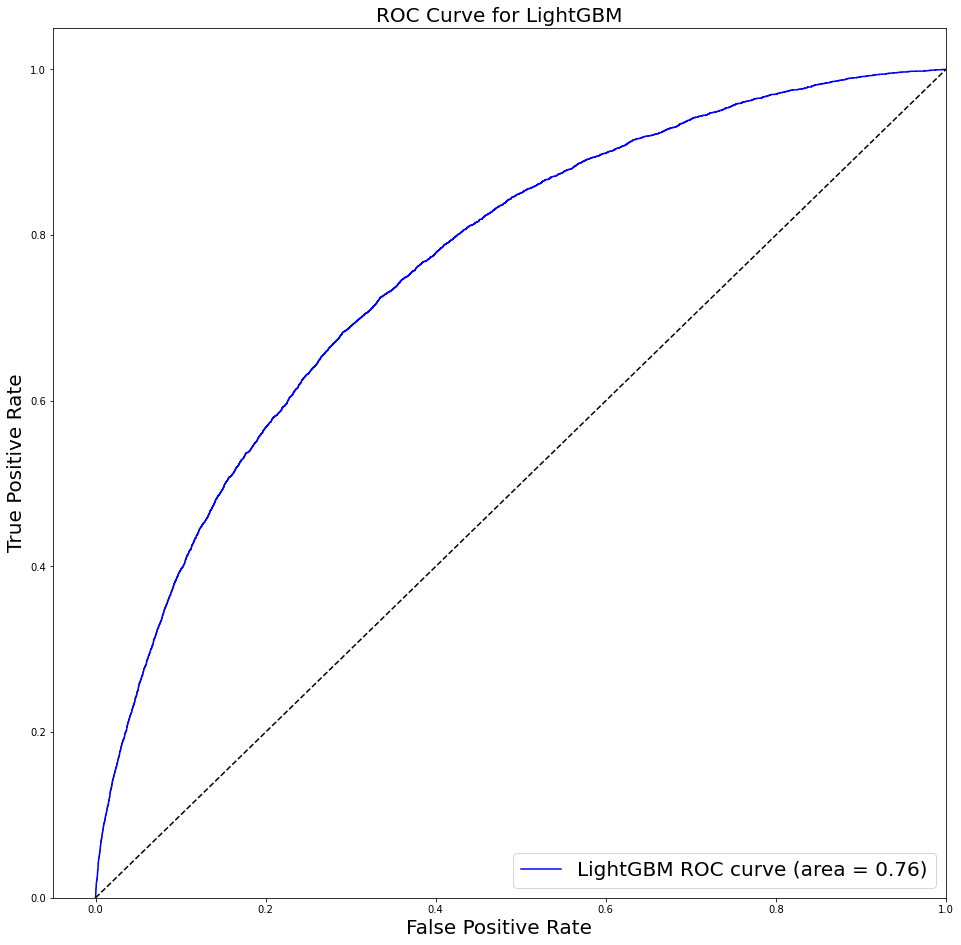

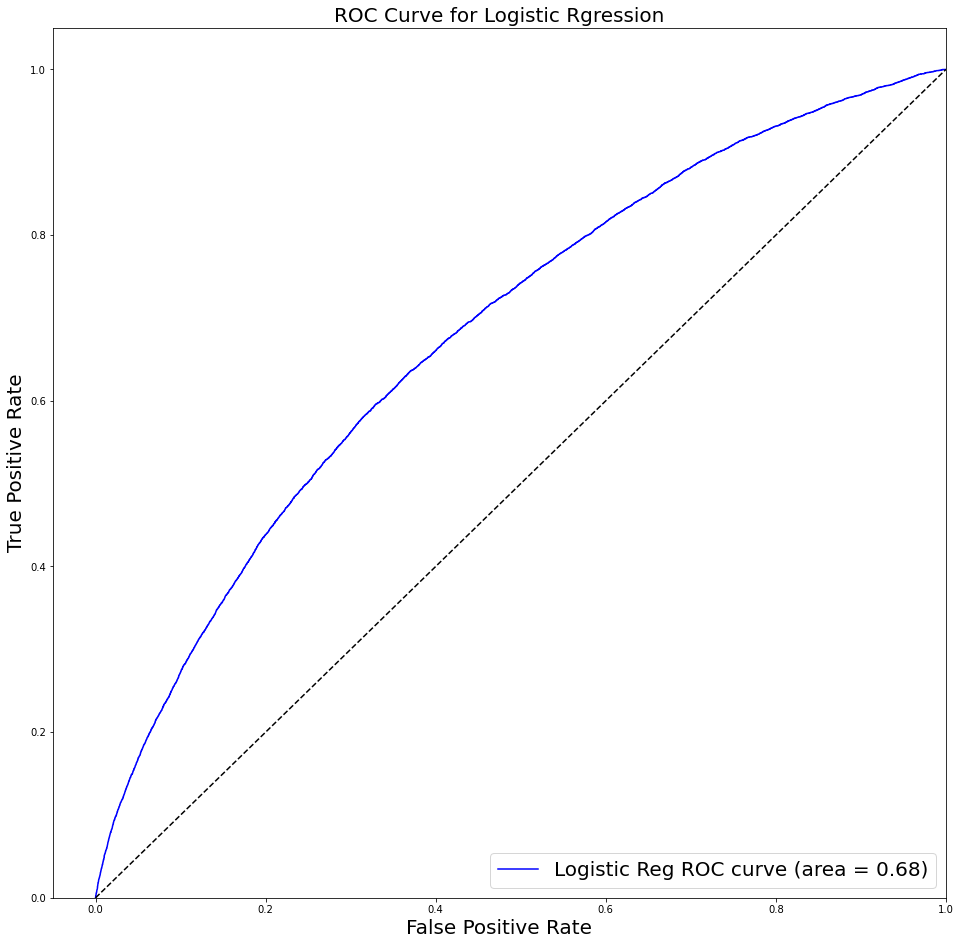

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc
# ROC curve of LightGBM
false_pos_rate1, true_pos_rate1, _ = roc_curve(lightgbm_first_fold_labels, lightgbm_first_fold_probs)
roc_auc1 = auc(false_pos_rate1, true_pos_rate1)

false_pos_rate2, true_pos_rate2, _ = roc_curve(first_fold_labels, first_fold_probs)
roc_auc2 = auc(false_pos_rate2, true_pos_rate2)

fig1, ax1 = plt.subplots(1, 1, figsize=(16,16))

ax1.plot(false_pos_rate1, true_pos_rate1, label='LightGBM ROC curve (area = %0.2f)' % roc_auc1, color='b')

ax1.set_title('ROC Curve for LightGBM', fontsize = 20)

for ax in fig1.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize = 20)
    ax.set_ylabel('True Positive Rate', fontsize = 20)
    ax.legend(loc="lower right", fontsize = 20)

fig2, ax2 = plt.subplots(1, 1, figsize=(16,16))
ax2.plot(false_pos_rate2, true_pos_rate2, label='Logistic Reg ROC curve (area = %0.2f)' % roc_auc2, color='b')
ax2.set_title('ROC Curve for Logistic Rgression', fontsize = 20)
for ax in fig2.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize = 20)
    ax.set_ylabel('True Positive Rate', fontsize = 20)
    ax.legend(loc="lower right", fontsize = 20)

In [ ]:
#!ls

In [ ]:
!mv first_fold_save_shuffled.csv ./drive/MyDrive/MATH4995Project1/
!mv first_fold_save_shuffled_change_lr.csv ./drive/MyDrive/MATH4995Project1/

In [ ]:
#submission_raw.to_csv("lightgbm_v1.csv", index = False)

In [ ]:
#metrics_raw.to_csv("lightgbm_v1_metrics_raw.csv", index = False)